## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 正規化

In [26]:
import os
import random
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

In [27]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="number"), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42
                                                    ) 

In [29]:
# 欠損値の除去
X_train = X_train.fillna(X_train.median())
X_train = X_train.dropna(axis=1)

X_test = X_test.fillna(X_test.median())
X_test = X_test.dropna(axis=1)

## 標準化・正規化前

In [30]:
# データセットを登録
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [31]:
params = {
          'task': 'train',                      # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          }

In [32]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 5
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	Train's rmse: 0.186339	Test's rmse: 0.242908


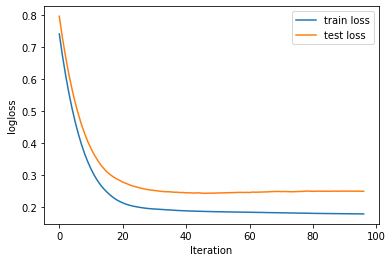

In [33]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [34]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

0.24290787668071306


## 標準化後

In [35]:
sc = StandardScaler()

In [36]:
X_train_sc = pd.DataFrame(
                            sc.fit_transform(X_train),
                            columns=X_train.columns
                            )

In [37]:
X_test_sc = pd.DataFrame(
                            sc.transform(X_test),
                            columns=X_test.columns
                            )

In [38]:
# データセットを登録
lgb_train_sc = lgb.Dataset(X_train_sc, y_train)
lgb_test_sc = lgb.Dataset(X_test_sc, y_test, reference=lgb_train_sc)

In [39]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train_sc,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train_sc, lgb_test_sc], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 5
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	Train's rmse: 0.185752	Test's rmse: 0.242391


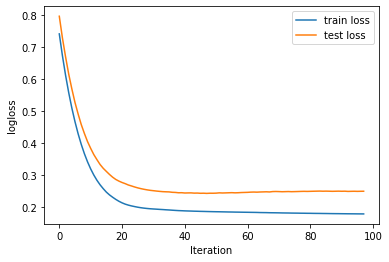

In [40]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [41]:
y_pred = model.predict(X_test_sc)

rmse_sc = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_sc)

0.24239129822702232


## 標準化

In [42]:
nl = MinMaxScaler()

In [43]:
X_train_mm = pd.DataFrame(
                            nl.fit_transform(X_train),
                            columns=X_train.columns
                            )

In [44]:
X_test_mm = pd.DataFrame(
                            nl.transform(X_test),
                            columns=X_test.columns
                            )

In [45]:
# データセットを登録
lgb_train_mm = lgb.Dataset(X_train_mm, y_train)
lgb_test_mm = lgb.Dataset(X_test_mm, y_test, reference=lgb_train_mm)

In [46]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train_mm,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train_mm, lgb_test_mm], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 5
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182075	Test's rmse: 0.254707


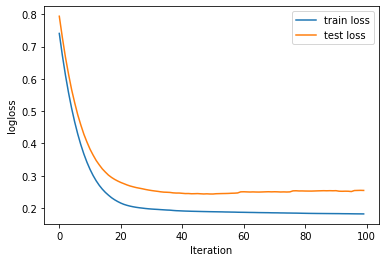

In [47]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [48]:
y_pred = model.predict(X_test_mm)

rmse_mm = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_mm)

0.25470676902648787


In [49]:
print("標準化・正規化前 RMSE:", round(rmse, 4))
print("標準化後 RMSE:", round(rmse_sc, 4))
print("正規化後 RMSE:", round(rmse_mm, 4))

標準化・正規化前 RMSE: 0.2429
標準化後 RMSE: 0.2424
正規化後 RMSE: 0.2547
